In [70]:
#packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score, f1_score, confusion_matrix,
    roc_auc_score, roc_curve

)
from xgboost import XGBClassifier

## Load Data

In [71]:
# load data set
df = pd.read_csv('WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.tail()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes
7042,3186-AJIEK,Male,0,No,No,66,Yes,No,Fiber optic,Yes,...,Yes,Yes,Yes,Yes,Two year,Yes,Bank transfer (automatic),105.65,6844.5,No


## Exploratory Data Analysis

In [72]:
# check shape, nulls, dtypes
df.info()
df.nunique()

# unique ID check
df['customerID'].is_unique

# detect mis-typed numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

# replace with median
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median())


# preview problematic rows
df[df['TotalCharges'].isna()][['customerID','tenure','MonthlyCharges','TotalCharges']]


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,tenure,MonthlyCharges,TotalCharges


In [73]:
# missing values
df.isna().sum().sort_values(ascending = False)

,0
customerID,0
gender,0
SeniorCitizen,0
Partner,0
Dependents,0
tenure,0
PhoneService,0
MultipleLines,0
InternetService,0
OnlineSecurity,0


In [74]:
# duplicates
df.duplicated('customerID').sum()

np.int64(0)

In [75]:
# outliers & range
df[['tenure','MonthlyCharges']].describe()

,tenure,MonthlyCharges
count,7043.000000,7043.000000
mean,32.371149,64.761692
std,24.559481,30.090047
min,0.000000,18.250000
25%,9.000000,35.500000
50%,29.000000,70.350000
75%,55.000000,89.850000
max,72.000000,118.750000


In [76]:
# target balance
df['Churn'].value_counts(normalize = True)

,proportion
Churn,
No,0.73463
Yes,0.26537


In [77]:
# dummify
obj_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
for c in obj_cols:
    df[c] = df[c].astype(str).str.strip()

tri_like = [
    'MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies'
]
for c in tri_like:
    if c in df.columns:
        df[c] = df[c].replace({
            'No internet service': 'No service',
            'No phone service': 'No service'
        })

ignore = {'customerID', 'Churn'}
cat_cols = [c for c in df.select_dtypes(include=['object', 'category']).columns if c not in ignore]

def is_yes_no_series(s):
    vals = set(s.dropna().unique())
    return vals.issubset({'Yes', 'No'}) and len(vals) > 0

bin_yesno = [c for c in cat_cols if is_yes_no_series(df[c])]
remaining = [c for c in cat_cols if c not in bin_yesno]
bin_other = [c for c in remaining if df[c].nunique(dropna = True) == 2]
multi = [c for c in remaining if df[c].nunique(dropna = True) >= 3]

for c in bin_yesno:
    df[c] = df[c].map({'Yes': 1, 'No': 0}).astype('int8')

for c in bin_other:
    d = pd.get_dummies(df[c], prefix = f'is_{c}', drop_first=True, dtype='int8')
    df[d.columns] = d
    df.drop(columns=[c], inplace = True)

if multi:
    d_multi = pd.get_dummies(df[multi],
                             prefix = [f'is_{c}' for c in multi],
                             columns = multi,
                             dtype='int8')
    df[d_multi.columns] = d_multi
    df.drop(columns = multi, inplace = True)



# target variable
df['ChurnFlag'] = df['Churn'].map({'Yes': 1, 'No': 0}).astype('int8')

df.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,is_StreamingMovies_No service,is_StreamingMovies_Yes,is_Contract_Month-to-month,is_Contract_One year,is_Contract_Two year,is_PaymentMethod_Bank transfer (automatic),is_PaymentMethod_Credit card (automatic),is_PaymentMethod_Electronic check,is_PaymentMethod_Mailed check,ChurnFlag
0,7590-VHVEG,0,1,0,1,0,1,29.85,29.85,No,...,0,0,1,0,0,0,0,1,0,0
1,5575-GNVDE,0,0,0,34,1,0,56.95,1889.50,No,...,0,0,0,1,0,0,0,0,1,0
2,3668-QPYBK,0,0,0,2,1,1,53.85,108.15,Yes,...,0,0,1,0,0,0,0,0,1,1
3,7795-CFOCW,0,0,0,45,0,0,42.30,1840.75,No,...,0,0,0,1,0,1,0,0,0,0
4,9237-HQITU,0,0,0,2,1,1,70.70,151.65,Yes,...,0,0,1,0,0,0,0,1,0,1


In [78]:
# derived features
df['has_internet'] = (df.get('is_InternetService__No', pd.Series(0, index = df.index)) == 0).astype('int8')

tri_yes_cols = [c for c in df.columns if c.startswith('is_OnlineSecurity__Yes')
                or c.startswith('is_OnlineBackup__Yes')
                or c.startswith('is_DeviceProtection__Yes')
                or c.startswith('is_TechSupport__Yes')
                or c.startswith('is_StreamingTV__Yes')
                or c.startswith('is_StreamingMovies__Yes')
                or c.startswith('is_MultipleLines__Yes')]

phone_bit = ['PhoneService'] if 'PhoneService' in df.columns else []

df['service_count'] = df[phone_bit + tri_yes_cols].sum(axis = 1).astype('int16')

df['avg_charge_per_service'] = (df['MonthlyCharges'] / np.maximum(df['service_count'], 1)).astype(float)

if 'is_Contract__Month-to-month' in df.columns:
    df['is_month_to_month'] = df['is_Contract__Month-to-month'].astype('int8')
else:
    if 'Contract' in df.columns:
        df['is_month_to_month'] = (df['Contract'] == 'Month-to-month').astype('int8')

df.head()

,customerID,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,is_Contract_One year,is_Contract_Two year,is_PaymentMethod_Bank transfer (automatic),is_PaymentMethod_Credit card (automatic),is_PaymentMethod_Electronic check,is_PaymentMethod_Mailed check,ChurnFlag,has_internet,service_count,avg_charge_per_service
0,7590-VHVEG,0,1,0,1,0,1,29.85,29.85,No,...,0,0,0,0,1,0,0,1,0,29.85
1,5575-GNVDE,0,0,0,34,1,0,56.95,1889.50,No,...,1,0,0,0,0,1,0,1,1,56.95
2,3668-QPYBK,0,0,0,2,1,1,53.85,108.15,Yes,...,0,0,0,0,0,1,1,1,1,53.85
3,7795-CFOCW,0,0,0,45,0,0,42.30,1840.75,No,...,1,0,1,0,0,0,0,1,0,42.30
4,9237-HQITU,0,0,0,2,1,1,70.70,151.65,Yes,...,0,0,0,0,1,0,1,1,1,70.70


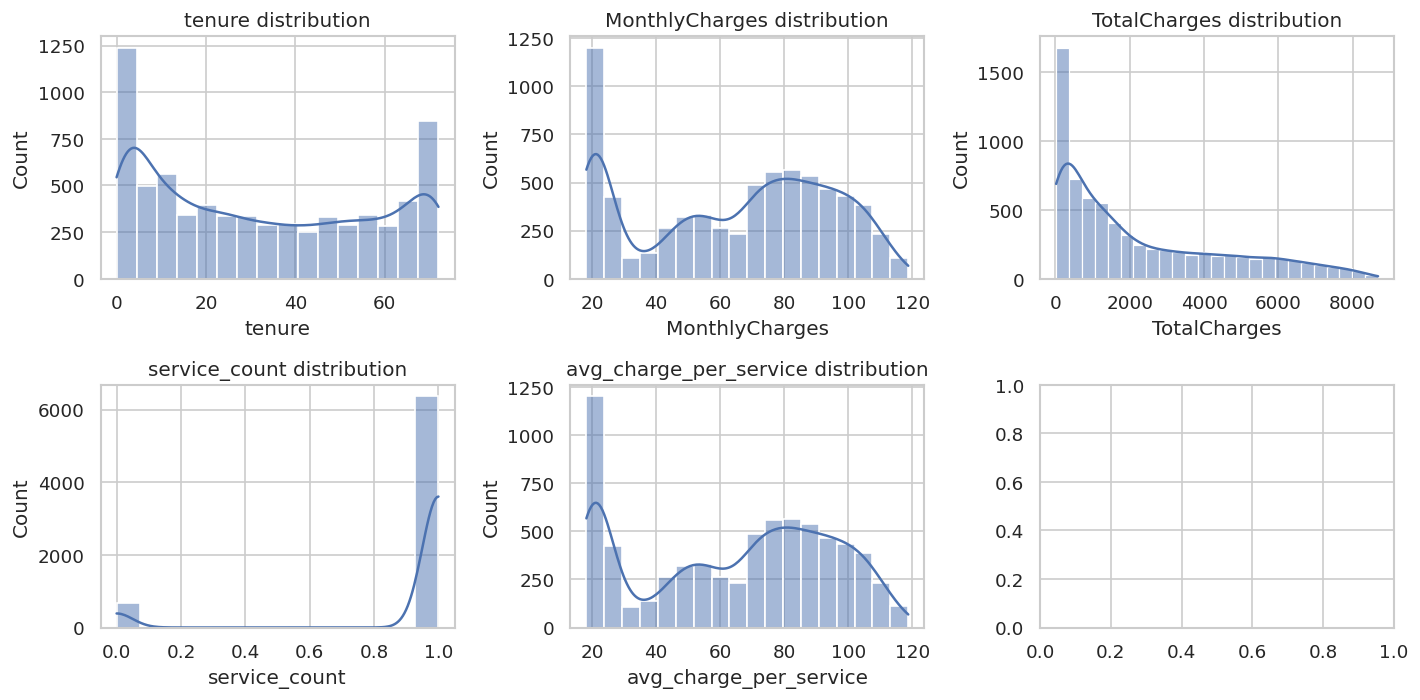

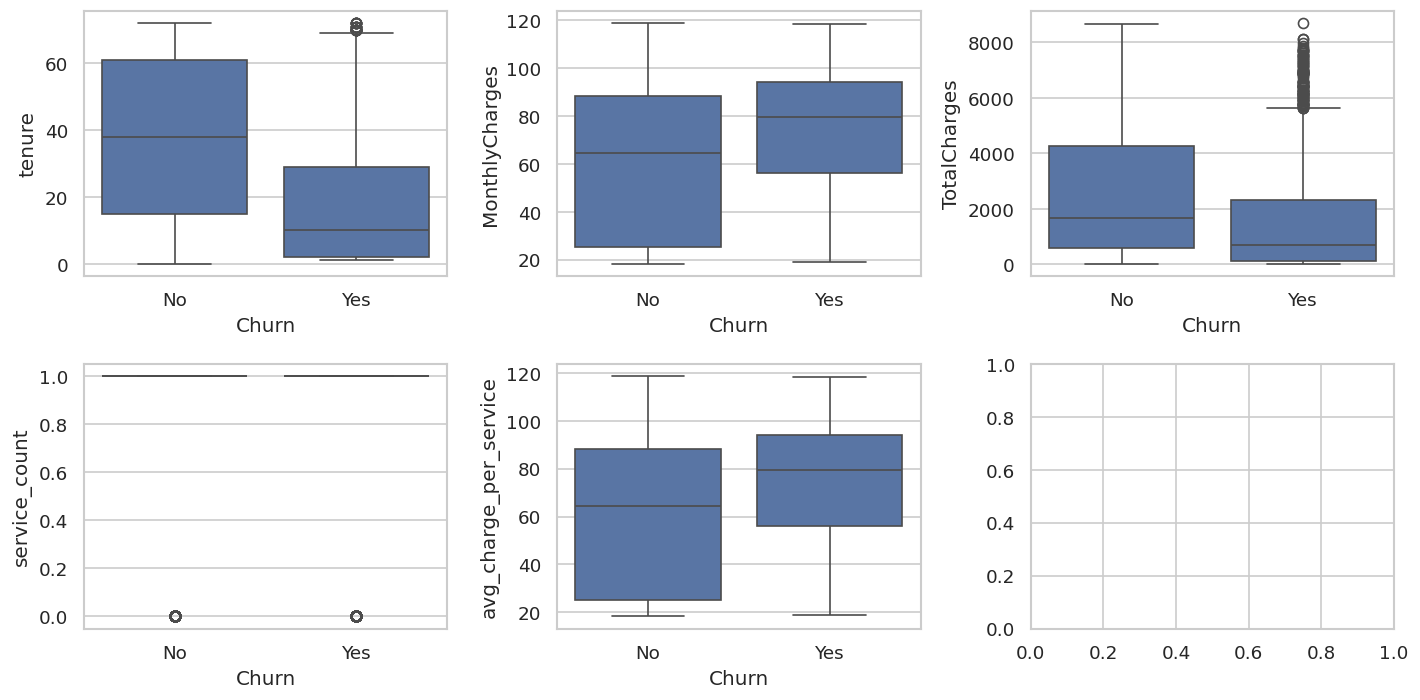

In [79]:
# distribution
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges', 'service_count', 'avg_charge_per_service']

fig, axes = plt.subplots(2, 3, figsize = (12, 6))
for ax, col in zip(axes.flatten(), num_cols):
    sns.histplot(df[col], kde = True, ax=ax)
    ax.set_title(f'{col} distribution')
plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 3, figsize = (12, 6))
sns.boxplot(x = 'Churn', y = 'tenure', data = df, ax = axes[0,0])
sns.boxplot(x = 'Churn', y = 'MonthlyCharges', data = df, ax = axes[0,1])
sns.boxplot(x = 'Churn', y = 'TotalCharges', data = df, ax = axes[0,2])
sns.boxplot(x = 'Churn', y = 'service_count', data = df, ax = axes[1,0])
sns.boxplot(x = 'Churn', y ='avg_charge_per_service', data = df, ax = axes[1,1])

plt.tight_layout()
plt.show()

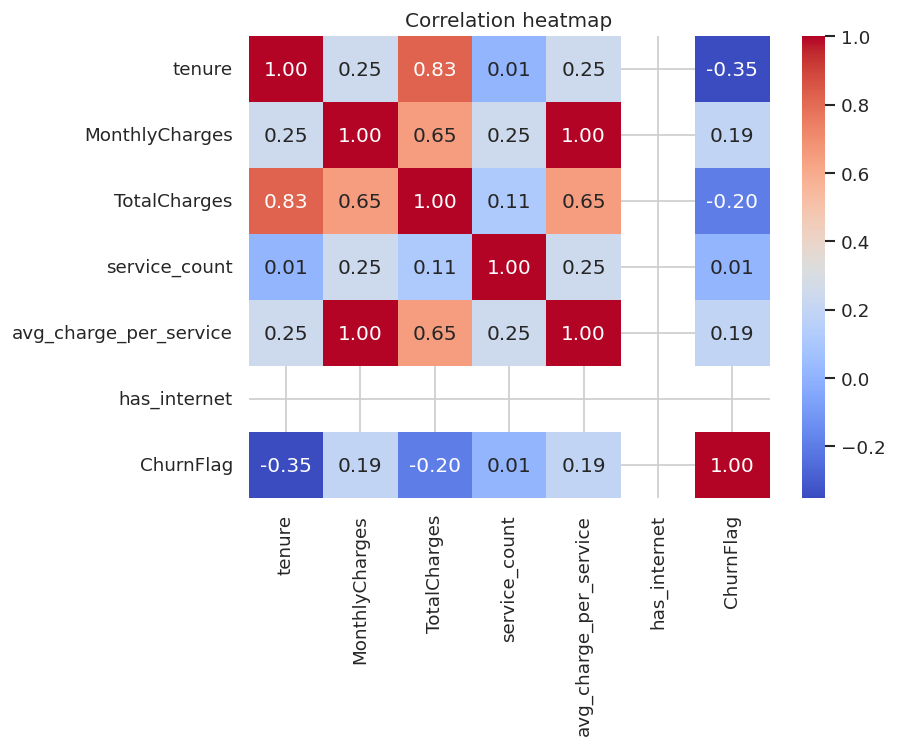

In [80]:
# correlation
corr_cols = ['tenure','MonthlyCharges','TotalCharges',
             'service_count','avg_charge_per_service',
             'has_internet','ChurnFlag']

plt.figure(figsize = (7,5))
sns.heatmap(df[corr_cols].corr(), annot = True, fmt = '.2f', cmap = 'coolwarm')
plt.title('Correlation heatmap')
plt.show()

## Model

=== Logistic Regression Results ===
Accuracy: 0.7409510290986515
F1 Score: 0.6161934805467929
ROC-AUC: 0.8409543000335838

Confusion Matrix:
 [[751 284]
 [ 81 293]]


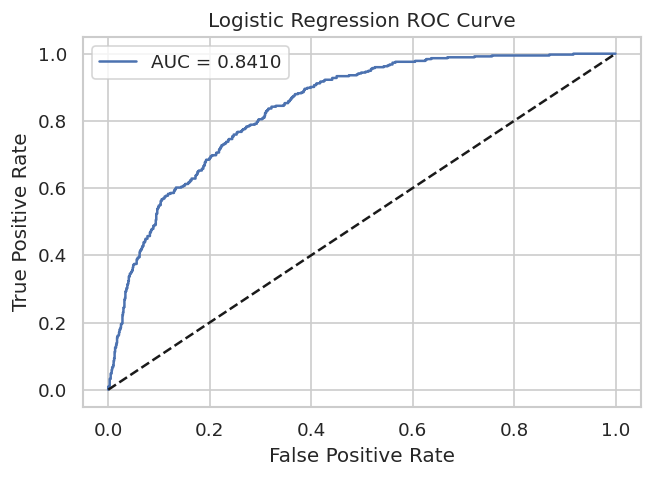

In [81]:
# model1: Logistic Regression
# train-test split
X = df.drop(['customerID', 'Churn', 'ChurnFlag'], axis=1, errors='ignore')
y = df['ChurnFlag']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42, stratify=y
)

# scale numeric features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# train
log_reg = LogisticRegression(
    max_iter=2000,
    class_weight='balanced'
)
log_reg.fit(X_train_scaled, y_train)

# predictions
y_pred = log_reg.predict(X_test_scaled)
y_prob = log_reg.predict_proba(X_test_scaled)[:, 1]

# evaluation
print("=== Logistic Regression Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred))
print("ROC-AUC:", roc_auc_score(y_test, y_prob))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

# plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_prob)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob):.4f}")
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.legend()
plt.show()

=== XGBoost Results ===
Accuracy: 0.7544357700496807
F1 Score: 0.6155555555555555
ROC-AUC: 0.8361737580407658

Confusion Matrix:
 [[786 249]
 [ 97 277]]


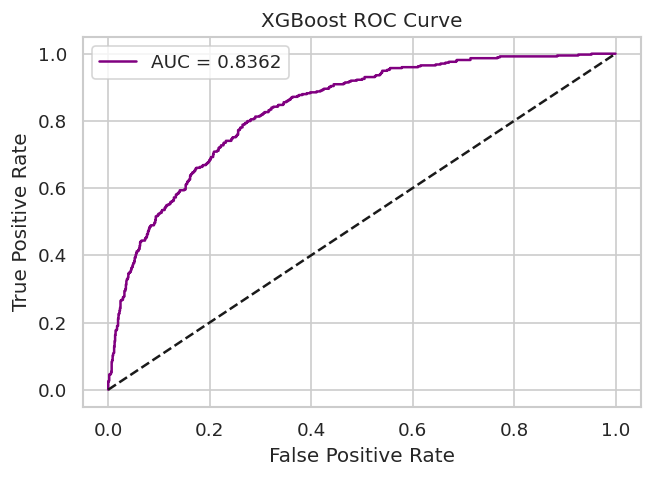

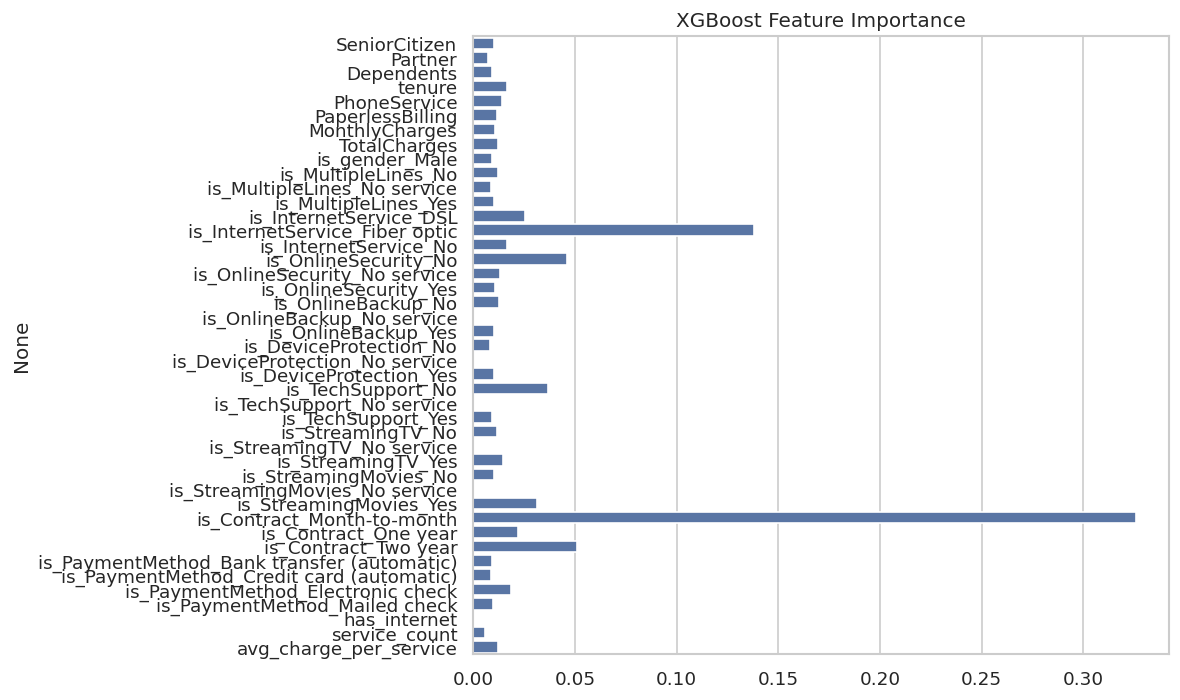

In [82]:
# model2: XGBoost
# train
xgb = XGBClassifier(
    max_depth = 5,
    learning_rate = 0.05,
    n_estimators = 300,
    subsample = 0.8,
    colsample_bytree = 0.8,
    eval_metric = 'logloss',
    scale_pos_weight = y.value_counts()[0] / y.value_counts()[1], # handling imbalance
    random_state = 42,
    n_jobs = -1
)

xgb.fit(X_train, y_train)

# predictions
y_pred_xgb = xgb.predict(X_test)
y_prob_xgb = xgb.predict_proba(X_test)[:, 1]

# evaluation
print("=== XGBoost Results ===")
print("Accuracy:", accuracy_score(y_test, y_pred_xgb))
print("F1 Score:", f1_score(y_test, y_pred_xgb))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))

# plot ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_xgb)
plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_prob_xgb):.4f}", color='purple')
plt.plot([0,1],[0,1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("XGBoost ROC Curve")
plt.legend()
plt.show()

# feature importance
plt.figure(figsize=(10,6))
sns.barplot(
    x=xgb.feature_importances_,
    y=X.columns
)
plt.title("XGBoost Feature Importance")
plt.tight_layout()
plt.show()

number of raw features: 43
categorical columns to encode: []
number of features after encoding: 43
 LTV Linear Regression Performance 
Train R^2 : 0.9985
Test  R^2 : 0.9988
Train RMSE : 30.60
Test  RMSE : 27.31

Top 15 features affecting LTV:
is_Contract_Month-to-month           5.167964
is_Contract_Two year                -5.102668
is_InternetService_Fiber optic       3.620105
is_StreamingTV_Yes                   2.299053
is_InternetService_DSL              -2.209023
is_OnlineBackup_Yes                  2.077425
Dependents                          -2.050899
is_StreamingMovies_Yes               2.025021
service_count                        1.937173
PhoneService                         1.937173
is_MultipleLines_No service         -1.937173
is_TechSupport_Yes                   1.740697
is_PaymentMethod_Electronic check   -1.453761
is_OnlineSecurity_No service        -1.411082
is_OnlineBackup_No service          -1.411082
dtype: float64


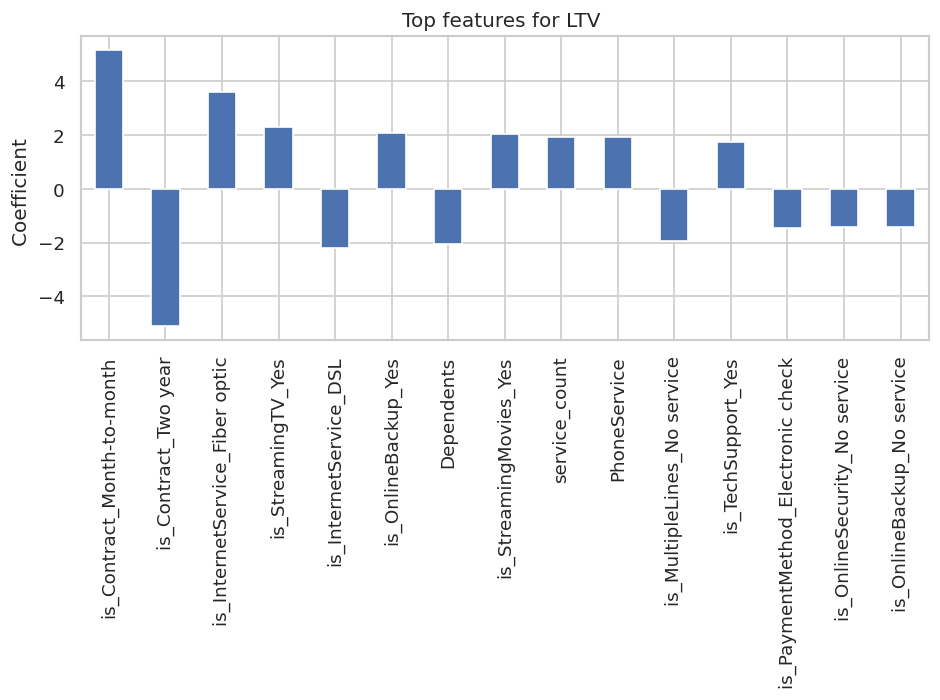

In [83]:
# Model 3: Linear regression

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
import matplotlib.pyplot as plt

# Check required columns
required_cols = ["MonthlyCharges", "tenure"]
for c in required_cols:
    if c not in df.columns:
        raise ValueError(f"Column {c} missing. Run preprocessing first.")

# Compute LTV
profit_margin = 0.35  # assumed profit margin 35%
df["LTV"] = df["MonthlyCharges"] * df["tenure"] * profit_margin

# Build feature matrix X and target y
y_ltv = df["LTV"]

X_ltv = df.drop(
    columns=["customerID", "Churn", "ChurnFlag", "LTV"],
    errors="ignore"
)

print("number of raw features:", X_ltv.shape[1])

# One-hot encode categorical (string) columns
cat_cols = X_ltv.select_dtypes(include=["object"]).columns.tolist()
print("categorical columns to encode:", cat_cols)

X_ltv_encoded = pd.get_dummies(
    X_ltv,
    columns=cat_cols,
    drop_first=True
)

print("number of features after encoding:", X_ltv_encoded.shape[1])

# Train-test split
X_train_ltv, X_test_ltv, y_train_ltv, y_test_ltv = train_test_split(
    X_ltv_encoded, y_ltv, test_size=0.2, random_state=42
)

# Fit Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train_ltv, y_train_ltv)

# Evaluate model
y_train_pred = lin_reg.predict(X_train_ltv)
y_test_pred = lin_reg.predict(X_test_ltv)

r2_train = r2_score(y_train_ltv, y_train_pred)
r2_test = r2_score(y_test_ltv, y_test_pred)
rmse_train = np.sqrt(mean_squared_error(y_train_ltv, y_train_pred))
rmse_test = np.sqrt(mean_squared_error(y_test_ltv, y_test_pred))

print(" LTV Linear Regression Performance ")
print(f"Train R^2 : {r2_train:.4f}")
print(f"Test  R^2 : {r2_test:.4f}")
print(f"Train RMSE : {rmse_train:.2f}")
print(f"Test  RMSE : {rmse_test:.2f}")

# Inspect top features by coefficient
coef_series = pd.Series(lin_reg.coef_, index=X_ltv_encoded.columns)
coef_sorted = coef_series.reindex(coef_series.abs().sort_values(ascending=False).index)

top_n = 15
print(f"\nTop {top_n} features affecting LTV:")
print(coef_sorted.head(top_n))

plt.figure(figsize=(8, 6))
coef_sorted.head(top_n).plot(kind="bar")
plt.title("Top features for LTV ")
plt.ylabel("Coefficient ")
plt.tight_layout()
plt.show()

K-Means clustering finished.
Cluster counts :
cluster
0    2166
1    2576
2     682
3    1619
Name: count, dtype: int64

===== Cluster Summary =====
         service_count  avg_charge_per_service  MonthlyCharges     tenure  \
cluster                                                                     
0                  1.0               92.430979       92.430979  56.654201   
1                  1.0               74.003591       74.003591  13.202252   
2                  0.0               42.028592       42.028592  31.737537   
3                  1.0               22.615411       22.615411  30.650401   

                 LTV  churn_rate  
cluster                           
0        1831.396241    0.173592  
1         345.537072    0.464674  
2         523.510909    0.249267  
3         250.364307    0.077826  


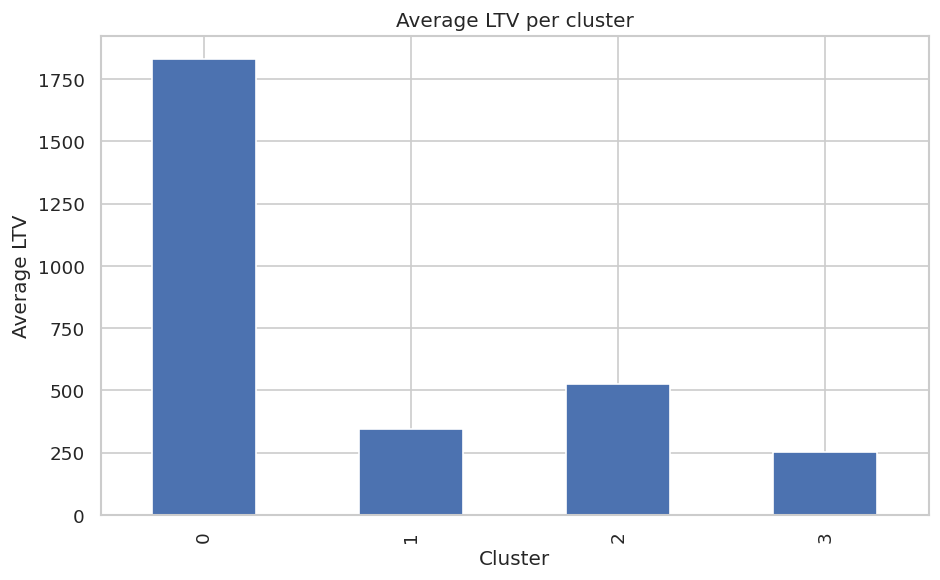

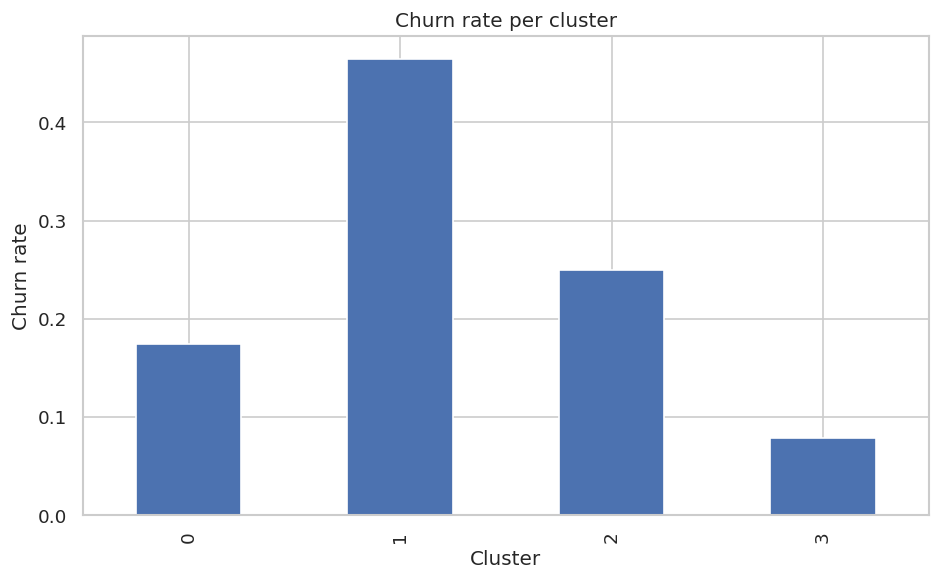

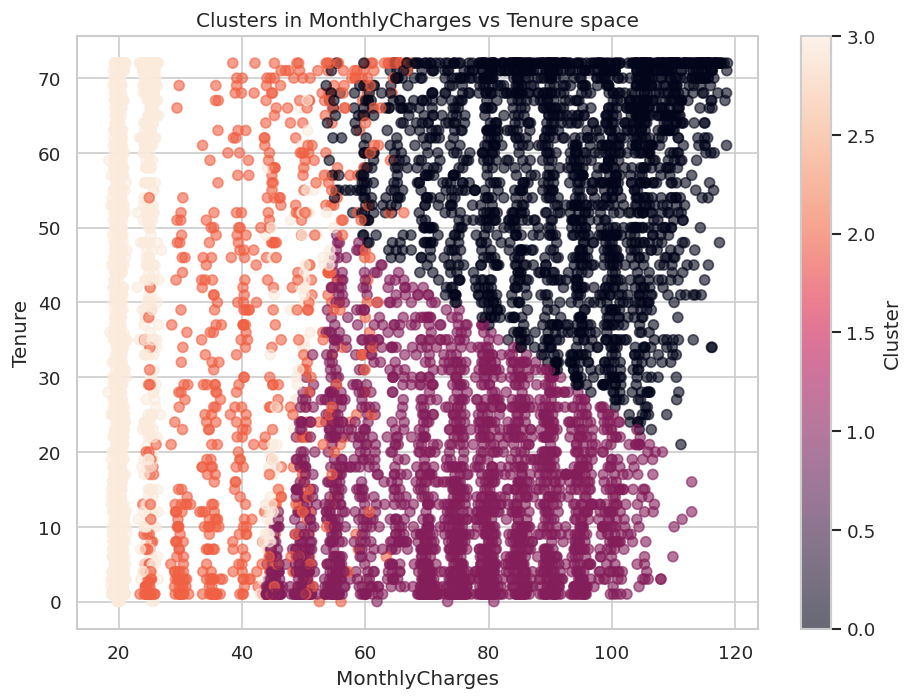

In [84]:
# Model 4: K-Means

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Select features for clustering
cluster_cols = [
    "service_count",
    "avg_charge_per_service",
    "MonthlyCharges",
    "tenure"
]

missing_cols = [c for c in cluster_cols if c not in df.columns]
if missing_cols:
    raise ValueError(f" {missing_cols}")

X_cluster = df[cluster_cols].copy()

# Standardize features for K-Means
scaler_cluster = StandardScaler()
X_cluster_scaled = scaler_cluster.fit_transform(X_cluster)

# Choose K
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df["cluster"] = kmeans.fit_predict(X_cluster_scaled)

print("K-Means clustering finished.")
print("Cluster counts :")
print(df["cluster"].value_counts().sort_index())

# Describe each cluster persona
if "LTV" not in df.columns:
    raise ValueError("not find column LTV")

if "ChurnFlag" not in df.columns:
    raise ValueError("not find column ChurnFlag")

cluster_summary = df.groupby("cluster").agg({
    "service_count": "mean",
    "avg_charge_per_service": "mean",
    "MonthlyCharges": "mean",
    "tenure": "mean",
    "LTV": "mean",
    "ChurnFlag": "mean"  # mean = churn rate
}).rename(columns={"ChurnFlag": "churn_rate"})

print("\n===== Cluster Summary =====")
print(cluster_summary)

#  LTV vs churn_rate
plt.figure(figsize=(8, 5))
cluster_summary["LTV"].plot(kind="bar")
plt.title("Average LTV per cluster")
plt.ylabel("Average LTV")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
cluster_summary["churn_rate"].plot(kind="bar")
plt.title("Churn rate per cluster")
plt.ylabel("Churn rate")
plt.xlabel("Cluster")
plt.tight_layout()
plt.show()

# MonthlyCharges vs tenure
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df["MonthlyCharges"],
    df["tenure"],
    c=df["cluster"],
    alpha=0.6
)
plt.colorbar(scatter, label="Cluster")
plt.xlabel("MonthlyCharges")
plt.ylabel("Tenure")
plt.title("Clusters in MonthlyCharges vs Tenure space")
plt.tight_layout()
plt.show()

## Optimization Simulation


===== Cluster LTV-Churn Trade-off=====
                 LTV  churn_rate  expected_value_index
cluster                                               
0        1831.396241    0.173592           1513.480735
1         345.537072    0.464674            184.975009
2         523.510909    0.249267            393.016987
3         250.364307    0.077826            230.879500


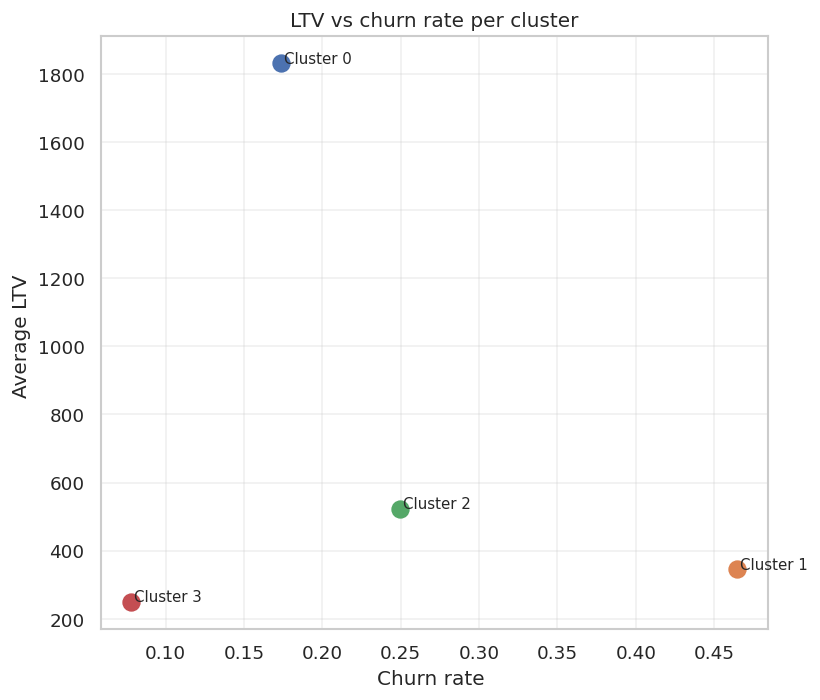

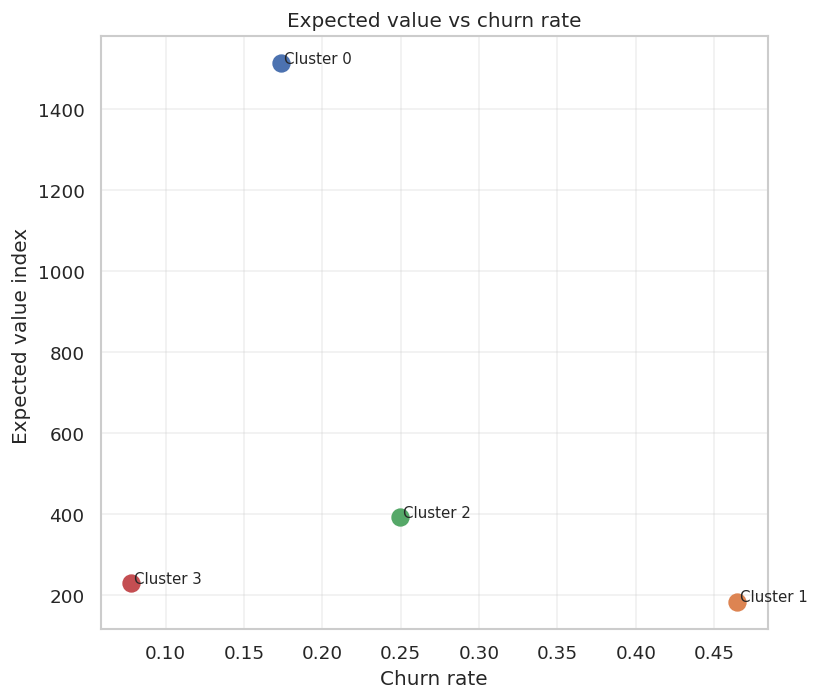

In [85]:
# LTV × Churn Trade-off

cluster_summary["expected_value_index"] = cluster_summary["LTV"] * (1 - cluster_summary["churn_rate"])

print("\n===== Cluster LTV-Churn Trade-off=====")
print(cluster_summary[["LTV", "churn_rate", "expected_value_index"]])


plt.figure(figsize=(7, 6))
for cl, row in cluster_summary.iterrows():
    plt.scatter(row["churn_rate"], row["LTV"], s=100)
    plt.text(row["churn_rate"] + 0.002, row["LTV"], f"Cluster {cl}", fontsize=9)

plt.xlabel("Churn rate ")
plt.ylabel("Average LTV ")
plt.title("LTV vs churn rate per cluster")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

plt.figure(figsize=(7, 6))
for cl, row in cluster_summary.iterrows():
    plt.scatter(row["churn_rate"], row["expected_value_index"], s=100)
    plt.text(row["churn_rate"] + 0.002, row["expected_value_index"], f"Cluster {cl}", fontsize=9)

plt.xlabel("Churn rate")
plt.ylabel("Expected value index ")
plt.title("Expected value vs churn rate")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

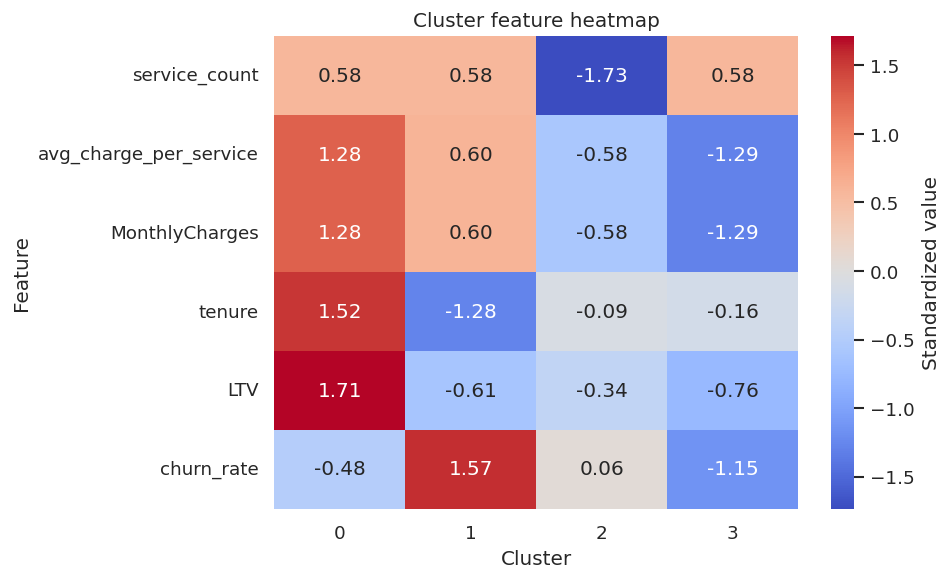

In [86]:
# Visualization 1: Cluster Heatmap

import seaborn as sns
import matplotlib.pyplot as plt

# features to show in heatmap
heatmap_features = [
    "service_count",
    "avg_charge_per_service",
    "MonthlyCharges",
    "tenure",
    "LTV",
    "churn_rate"
]

# take cluster means for those features
heatmap_data = cluster_summary[heatmap_features].copy()

# standardize each column
heatmap_norm = (heatmap_data - heatmap_data.mean()) / heatmap_data.std(ddof=0)

plt.figure(figsize=(8, 5))
sns.heatmap(
    heatmap_norm.T,           # rows: features, cols: clusters
    annot=True,               # show values in cells
    fmt=".2f",
    cmap="coolwarm",          # blue-red gradient
    cbar_kws={"label": "Standardized value"}
)
plt.title("Cluster feature heatmap")
plt.xlabel("Cluster")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

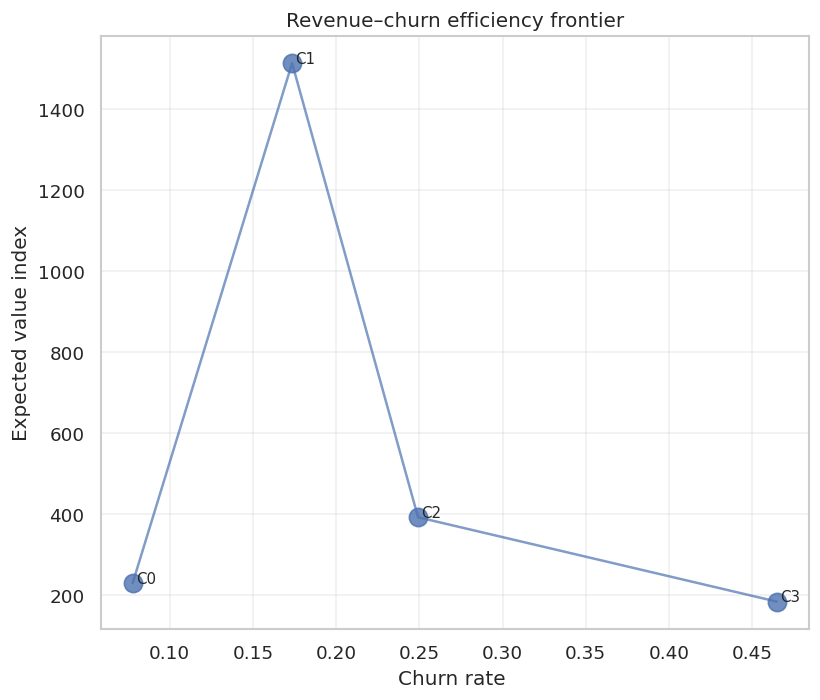

In [87]:
# Visualization 2: Revenue-Churn Efficiency Frontier

# prepare a tidy dataframe for plotting
frontier_df = cluster_summary.reset_index().rename(columns={"cluster": "cluster_id"})

if "cluster_id" not in frontier_df.columns:
    frontier_df.rename(columns={"index": "cluster_id"}, inplace=True)

# sort by churn_rate
frontier_df = frontier_df.sort_values("churn_rate").reset_index(drop=True)

plt.figure(figsize=(7, 6))

# scatter: each cluster as a point
plt.scatter(
    frontier_df["churn_rate"],
    frontier_df["expected_value_index"],
    s=120,
    alpha=0.8
)

# connect points with lines to form frontier
plt.plot(
    frontier_df["churn_rate"],
    frontier_df["expected_value_index"],
    linewidth=1.5,
    alpha=0.7
)

# add text labels
for _, row in frontier_df.iterrows():
    plt.text(
        row["churn_rate"] + 0.002,
        row["expected_value_index"],
        f"C{int(row.name)}",
        fontsize=9
    )

plt.xlabel("Churn rate ")
plt.ylabel("Expected value index")
plt.title("Revenue–churn efficiency frontier")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()